In [77]:
import os
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import time

In [104]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available:  []


In [44]:
# Download latest version

path = kagglehub.dataset_download("varpit94/disaster-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1


In [45]:
# Download latest version

path = kagglehub.dataset_download("mikolajbabula/disaster-images-dataset-cnn-model")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\kevwi\.cache\kagglehub\datasets\mikolajbabula\disaster-images-dataset-cnn-model\versions\1


In [71]:
# Define the path to the downloaded dataset

images_dataset_path = r"C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1"
base_path = os.path.join(images_dataset_path, "Comprehensive Disaster Dataset(CDD)")

In [72]:
# Step 1: Organize the data into disaster and non-disaster categories
disaster_dirs = [
    os.path.join(base_path, "Damaged_Infrastructure", "Earthquake"),
    os.path.join(base_path, "Damaged_Infrastructure", "Infrastructure"),
    os.path.join(base_path, "Fire_Disaster", "Urban_Fire"),
    os.path.join(base_path, "Fire_Disaster", "Wild_Fire"),
    os.path.join(base_path, "Human_Damage"),
    os.path.join(base_path, "Land_Disaster", "Drought"),
    os.path.join(base_path, "Land_Disaster", "Land_Slide"),
    os.path.join(base_path, "Water_Disaster")
]

non_disaster_dirs = [
    os.path.join(base_path, "Non_Damage", "human"),
    os.path.join(base_path, "Non_Damage", "Non_Damage_Buildings_Street"),
    os.path.join(base_path, "Non_Damage", "Non_Damage_Wildlife_Forest"),
    os.path.join(base_path, "Non_Damage", "sea")
]

In [73]:
# Step 2: Create lists of image paths and labels

image_paths = []
labels = []  # 0 for non-disaster, 1 for disaster

In [74]:
# Add disaster images

for directory in disaster_dirs:
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            if filename.lower().endswith('.png'):
                image_paths.append(os.path.join(directory, filename))
                labels.append(1)  # 1 for disaster

In [75]:
# Add non-disaster images

for directory in non_disaster_dirs:
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            if filename.lower().endswith('.png'):
                image_paths.append(os.path.join(directory, filename))
                labels.append(0)  # 0 for non-disaster

In [76]:
# Print dataset information

print(f"Total images: {len(image_paths)}")
print(f"Disaster images: {labels.count(1)}")
print(f"Non-disaster images: {labels.count(0)}")

Total images: 13557
Disaster images: 4320
Non-disaster images: 9237


In [78]:
# Step 3: Split the data into training, validation, and test sets
# First, combine image paths and labels

data = list(zip(image_paths, labels))
random.shuffle(data)
image_paths, labels = zip(*data)

In [81]:
# Convert back to list

image_paths = list(image_paths)
labels = list(labels)

In [82]:
# Split into train (80%) and temp (20%)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

In [83]:
# Split temp into validation (10%) and test (10%)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

In [84]:
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Test images: {len(test_paths)}")

Training images: 10845
Validation images: 1356
Test images: 1356


In [85]:
# Step 4: Create data generators with augmentation for training

img_height, img_width = 180, 180  # Keep same size as before

In [86]:
# Data augmentation for training

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [87]:
# Rescaling for validation and test

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [92]:
# Function to create a generator from paths and labels

def create_generator(paths, labels, datagen, batch_size=32):
    while True:
        # Create batches
        batch_paths = []
        batch_labels = []
        
        # Get a batch of paths and labels
        for i in range(batch_size):
            idx = random.randint(0, len(paths) - 1)
            batch_paths.append(paths[idx])
            batch_labels.append(labels[idx])
        
        # Process images
        batch_images = []
        for path in batch_paths:
            try:
                img = tf.keras.preprocessing.image.load_img(
                    path, target_size=(img_height, img_width))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img_array)
            except Exception as e:
                print(f"Error loading image {path}: {e}")
                # Replace with a black image if there's an error
                batch_images.append(np.zeros((img_height, img_width, 3)))
        
        # Convert to numpy arrays
        batch_images = np.array(batch_images) / 255.0
        batch_labels = np.array(batch_labels)
        
        # Apply data augmentation
        for i in range(len(batch_images)):
            batch_images[i] = datagen.random_transform(batch_images[i])
        
        yield batch_images, batch_labels

In [93]:
# Step 5: Create the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [94]:
# Create a CNN model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (0=non-disaster, 1=disaster)
])

C:\Users\kevwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
# Compile the model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [96]:
# Display model summary

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Step 6: Set up callbacks

checkpoint = ModelCheckpoint(
    'disaster_model_best.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [100]:
# Step 7: Train the model

batch_size = 32
epochs = 20

In [101]:
# Calculate steps per epoch and validation steps

steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size

In [102]:
# Create generators

train_generator = create_generator(train_paths, train_labels, train_datagen, batch_size)
val_generator = create_generator(val_paths, val_labels, val_datagen, batch_size)

In [105]:
# Train the model

print("Starting model training...")
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

Starting model training...
Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.7713 - loss: 0.4758
Epoch 1: val_accuracy improved from 0.75893 to 0.81548, saving model to disaster_model_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 109s 322ms/step - accuracy: 0.7713 - loss: 0.4757 - val_accuracy: 0.8155 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 2/20
279/338 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step - accuracy: 0.8378 - loss: 0.3795Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Human_Damage\02_0069.png: cannot identify image file <_io.BytesIO object at 0x000001EF974630B0>
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8366 - loss: 0.3810
Epoch 2: val_accuracy did not improve from 0.81548
338/338 ━━━━━━━━━━━━━━━━━━━━ 116s 342ms/step - accuracy: 0.8366 - loss: 0.3811 - val_accuracy: 0.8103 - val_loss: 0.5319 - learning_rate: 0.0010
Epoch 3/20
 15/338 ━━━━━━━━━━━━━━━━━━━━ 1:50 341ms/step - accuracy: 0.8533 - loss: 0.3340Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Human_Damage\02_0069.png: c

338/338 ━━━━━━━━━━━━━━━━━━━━ 133s 393ms/step - accuracy: 0.8386 - loss: 0.3612 - val_accuracy: 0.8222 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 4/20
153/338 ━━━━━━━━━━━━━━━━━━━━ 1:03 344ms/step - accuracy: 0.8574 - loss: 0.3330Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Human_Damage\02_0069.png: cannot identify image file <_io.BytesIO object at 0x000001EF7FFC1C10>
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8566 - loss: 0.3313
Epoch 4: val_accuracy improved from 0.82217 to 0.85938, saving model to disaster_model_best.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 107s 316ms/step - accuracy: 0.8566 - loss: 0.3312 - val_accuracy: 0.8594 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 5/20
 35/338 ━━━━━━━━━━━━━━━━━━━━ 1:00 198ms/step - accuracy: 0.8766 - loss: 0.2868Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Human_Damage\02_0069.png: cannot identify image file <_io.BytesIO object at 0x000001EF675A31A0>
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8728 - loss: 0.3064
Epoch 5: val_accuracy did not improve from 0.85938
338/338 ━━━━━━━━━━━━━━━━━━━━ 91s 269ms/step - accuracy: 0.8728 - loss: 0.3064 - val_accuracy: 0.8244 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 6/20
235/338 ━━━━━━━━━━━━━━━━━━━━ 26s 254ms/step - accuracy: 0.8951 - loss: 0.2601Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Human_Damage\02_0069.png: ca

338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 267ms/step - accuracy: 0.8951 - loss: 0.2595 - val_accuracy: 0.9234 - val_loss: 0.1918 - learning_rate: 0.0010
Epoch 7/20
103/338 ━━━━━━━━━━━━━━━━━━━━ 56s 239ms/step - accuracy: 0.8978 - loss: 0.2546Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Human_Damage\02_0069.png: cannot identify image file <_io.BytesIO object at 0x000001EF675A31A0>
130/338 ━━━━━━━━━━━━━━━━━━━━ 51s 246ms/step - accuracy: 0.8978 - loss: 0.2548Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Human_Damage\02_0069.png: cannot identify image file <_io.BytesIO object at 0x000001EF67588090>
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9019 - loss: 0.2452
Epoch 7: val_accuracy did not improve from 0.92336
338/338 ━━━━━━━━━━━━━━━━━━━━ 109s 323ms/step - accuracy: 0.9020 - loss: 0.2452 - val_accu

In [106]:
# Step 8: Evaluate on the test set

test_generator = create_generator(test_paths, test_labels, test_datagen, batch_size)
test_steps = len(test_paths) // batch_size

print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

Evaluating on test set...
30/42 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.9408 - loss: 0.2404Error loading image C:\Users\kevwi\.cache\kagglehub\datasets\varpit94\disaster-images-dataset\versions\1\Comprehensive Disaster Dataset(CDD)\Damaged_Infrastructure\Infrastructure\05_01_0261.png: image file is truncated (0 bytes not processed)
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - accuracy: 0.9388 - loss: 0.2317
Test accuracy: 0.9338
Test loss: 0.2158


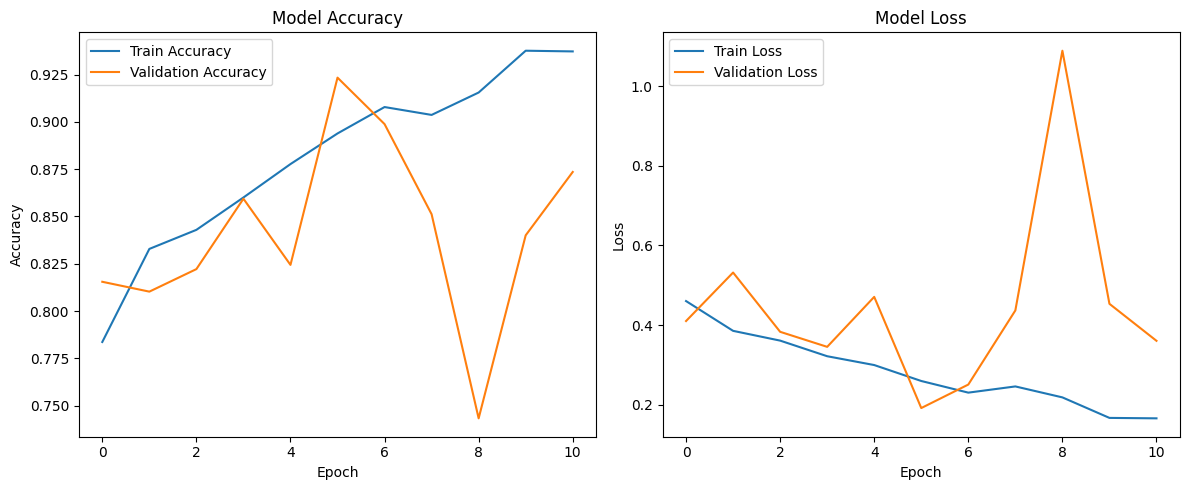

In [107]:
# Step 9: Plot training history

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [108]:
# Step 10: Test on some sample images

def predict_and_display(image_paths, true_labels, num_samples=4):
    # Choose random samples
    indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        true_label = true_labels[idx]
        
        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        prediction = model.predict(img_array, verbose=0)[0][0]
        predicted_label = 1 if prediction > 0.5 else 0
        
        # Display
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f"True: {'Disaster' if true_label==1 else 'Non-Disaster'}\n"
                 f"Pred: {'Disaster' if predicted_label==1 else 'Non-Disaster'} "
                 f"({prediction:.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Testing on sample disaster images:


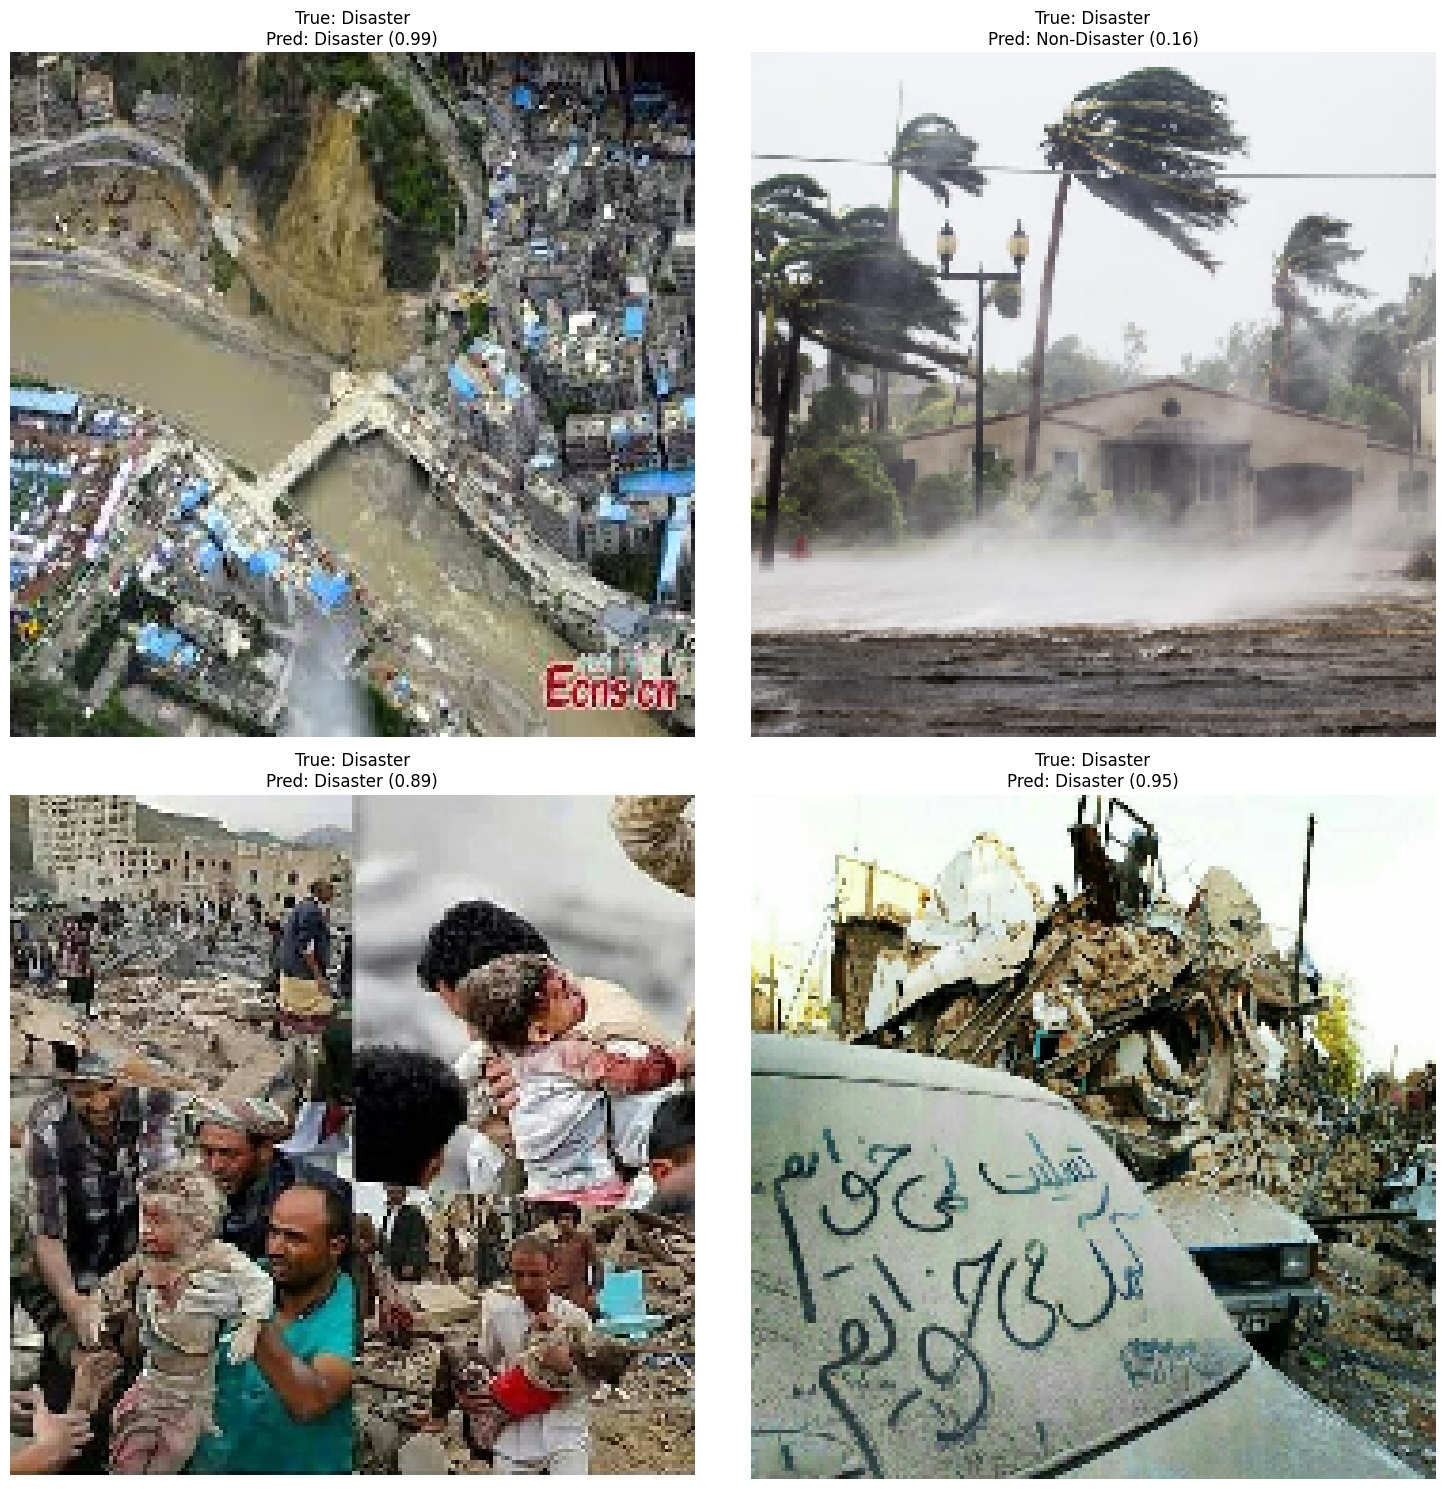


Testing on sample non-disaster images:


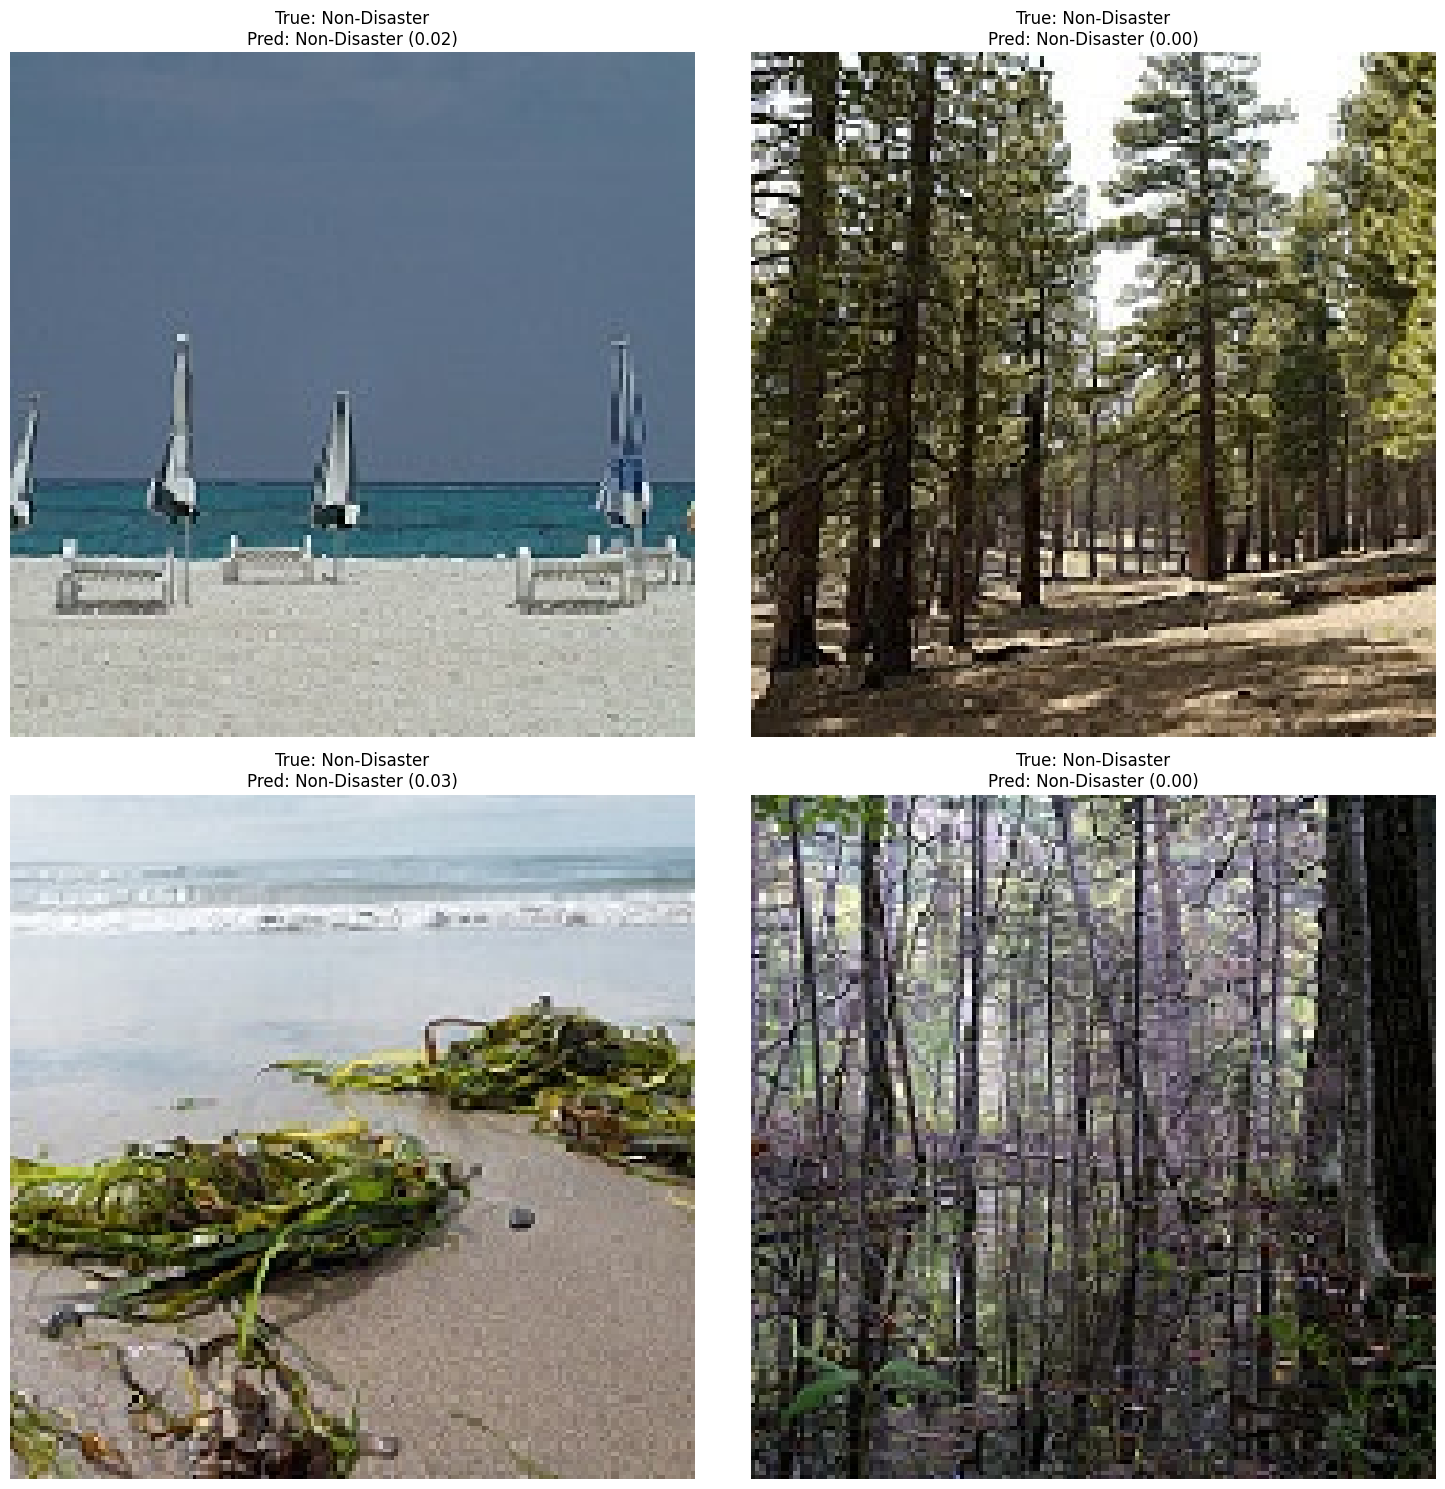

In [109]:
# Test on disaster and non-disaster images

print("\nTesting on sample disaster images:")
disaster_test_idx = [i for i, label in enumerate(test_labels) if label == 1]
disaster_test_paths = [test_paths[i] for i in disaster_test_idx]
disaster_test_labels = [test_labels[i] for i in disaster_test_idx]
predict_and_display(disaster_test_paths, disaster_test_labels)

print("\nTesting on sample non-disaster images:")
non_disaster_test_idx = [i for i, label in enumerate(test_labels) if label == 0]
non_disaster_test_paths = [test_paths[i] for i in non_disaster_test_idx]
non_disaster_test_labels = [test_labels[i] for i in non_disaster_test_idx]
predict_and_display(non_disaster_test_paths, non_disaster_test_labels)

In [110]:
# Save the trained model

model.save('disaster_detection_model_final.h5')
print("\nModel saved as 'disaster_detection_model_final.h5'")


Model saved as 'disaster_detection_model_final.h5'
